# Description
Visualize the 4D latent space of the cell images compressed by ONN encoder.
Apply unsupervised clustering algorithms to identify both the normal and abnormal cell clusters.

# Load Libraries

In [2]:
from __future__ import print_function
import os, sys
import math
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.swa_utils import AveragedModel, SWALR
from torch.optim.lr_scheduler import CosineAnnealingLR
import optuna
import ray

import wandb
from torchvision import datasets, transforms

In [3]:
""" Training and hyperparameter search configurations """

parser = argparse.ArgumentParser(description='PyTorch QuickDraw Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--wandb', action='store_true', default=True, 
                    help='enables wandb logger')  
parser.add_argument('--epochs', type=int, default=5000, metavar='N',
                    help='number of epochs to train (default: 100)')
args = parser.parse_args("")
args.cuda = not args.no_cuda and torch.cuda.is_available()

# Set random seeds to reproduce results
torch.manual_seed(42)
if args.cuda:
    torch.cuda.manual_seed(42)

# Dataloaders

In [4]:
""" Construct a dataset object from data. """

class EBI_Cell_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_import, label_import, targets, data_transforms=None):
        self.physical_ground_truth = torch.tensor(data_import, dtype = torch.float32)
        self.labels = torch.tensor(label_import, dtype = torch.long)
        self.digital_ground_truth = torch.tensor(targets, dtype = torch.float32)
        self.class_dict = {}
        self.transform = data_transforms
                
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        data = self.physical_ground_truth[idx]
        
        if self.transform:
             data = self.transform(self.physical_ground_truth[idx].unsqueeze(0))
            
        return data, self.labels[idx], self.digital_ground_truth[idx,:]

In [8]:
""" Dataloaders for input images (Train-test split does not matter for unsupervised learning.)"""

f = "./Cell_GT_images.npz"
train_GT = np.load(f)['train_data']
train_labels = np.load(f)['train_labels']
test_GT = np.load(f)['test_data']
test_labels = np.load(f)['test_labels']
train_grey = np.load('./EBI_Cells_w_anomaly.npz')['train_data_grey']
test_grey = np.load('./EBI_Cells_w_anomaly.npz')['test_data_grey']

def conv2d(NCHW_tensor):
    conv_ker = torch.tensor([[0.05, 0.1, 0.05], [0.1, 1, 0.1], [0.05, 0.1, 0.05]])
    conv_ker = conv_ker.view(1, 1, conv_ker.size(0), conv_ker.size(1))
    img_conv2d = F.conv2d(NCHW_tensor.unsqueeze(0), conv_ker, padding=1).squeeze(0)
    return img_conv2d/img_conv2d.max()

transforms_input = transforms.Compose([transforms.Lambda(lambda x: x.view(-1)), \
                                       transforms.Lambda(lambda x: x/200)])

transforms_input_distort = transforms.Compose([transforms.RandomAffine(0, translate=(0.05, 0.05), scale=(0.96, 1.04)), \
                                               transforms.Lambda(lambda x: x.view(-1)), \
                                               transforms.Lambda(lambda x: x/200)])

# transforms_digi = transforms.Compose([transforms.ToTensor(), \
#                                       transforms.Lambda(lambda x: x.view(-1))])

# transforms_digi_distort = transforms.Compose([transforms.ToTensor(), \
#                                               transforms.RandomAffine(0, translate=(0.05, 0.05), scale=(0.96, 1.04)), \
#                                               transforms.Lambda(lambda x: x.view(-1))])
kwargs = {}

""" input image loaders """
train_loader_phys_order = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(train_GT, train_labels, train_grey, transforms_input), \
    batch_size=1000, shuffle=False, **kwargs)

test_loader_phys_order = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(test_GT, test_labels, test_grey, transforms_input), \
    batch_size=505, shuffle=False, **kwargs)

""" input image loader w/. customerized samplers """
train_sampler = torch.utils.data.BatchSampler(\
                                              torch.utils.data.RandomSampler(range(train_GT.shape[0])), \
                                              batch_size=args.batch_size, drop_last=False)
test_sampler = torch.utils.data.BatchSampler(\
                                             torch.utils.data.RandomSampler(range(test_GT.shape[0])), \
                                             batch_size=args.test_batch_size, drop_last=False)

train_loader_phys = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(train_GT, train_labels, train_grey, transforms_input_distort), \
    batch_sampler = train_sampler, **kwargs)

test_loader_phys = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(test_GT, test_labels, test_grey, transforms_input), \
    batch_sampler = test_sampler, **kwargs)

In [11]:
""" Dataloaders (train-test split does not matter in this task, since it is unsupervised learning) """

unsupervised_data = np.load('./Train_Data_Cell_Nonlinear_with_anomaly.npz')
train_fc2 = torch.tensor(unsupervised_data['train_data_fc2'], dtype=torch.float32)
train_labels = torch.tensor(unsupervised_data['train_labels'])

unsupervised_data = np.load('./Test_Data_Cell_Nonlinear_with_anomaly.npz')
test_fc2 = torch.tensor(unsupervised_data['test_data_fc2'], dtype=torch.float32)
test_labels = torch.tensor(unsupervised_data['test_labels'])


transforms_fc1 = transforms.Compose([transforms.Lambda(lambda x: x.view(-1)), \
                                      transforms.Lambda(lambda x: x)])

transforms_act1 = transforms.Compose([transforms.Lambda(lambda x: x.view(-1)), \
                                      transforms.Lambda(lambda x: x/6000)])

transforms_fc2 = transforms.Compose([transforms.Lambda(lambda x: x.view(-1)), \
                                      transforms.Lambda(lambda x: x/10000)])

""" fc2 loader w/. built-in samplers """
train_loader_fc2_order = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(train_fc2, train_labels, train_grey, transforms_fc2), \
    batch_size=1000, shuffle=False, **kwargs)

test_loader_fc2_order = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(test_fc2, test_labels, test_grey, transforms_fc2), \
    batch_size=418, shuffle=False, **kwargs)

train_loader_fc2 = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(train_fc2, train_labels, train_grey, transforms_fc2), \
    batch_sampler=train_sampler,**kwargs)

test_loader_fc2 = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(test_fc2, test_labels, test_grey, transforms_fc2), \
    batch_sampler=test_sampler, **kwargs)

/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [12]:
# print(next(enumerate(train_loader_fc1))[1][0].shape)
# print(next(enumerate(train_loader_act1))[1][0].shape)
print(next(enumerate(train_loader_fc2))[1][0].shape)
print(next(enumerate(train_loader_fc2_order))[1][0].shape)
print(next(enumerate(test_loader_fc2_order))[1][0].shape)

torch.Size([128, 4])
torch.Size([1000, 4])
torch.Size([418, 4])


# Latent space and clustering

## visualize latent space

In [42]:
SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rcParams["font.family"] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

<IPython.core.display.Javascript object>


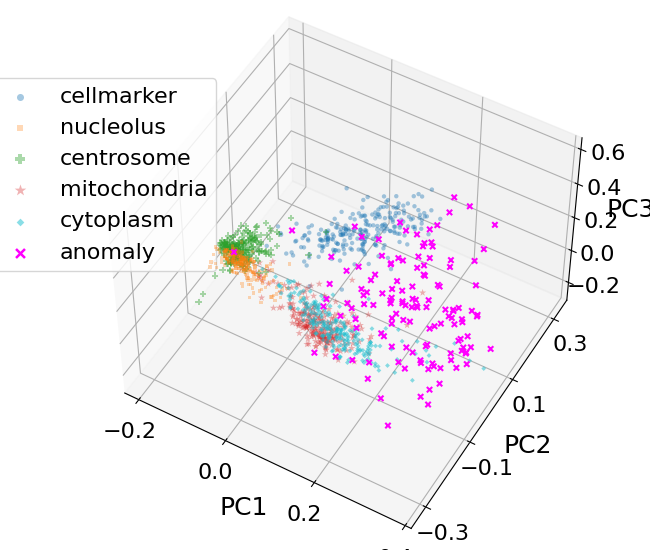

In [86]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torchvision

datain, labs, _ = next(enumerate(test_loader_fc2_order))[1]
latent = datain.detach().numpy()
datain0, labs0, _ = next(enumerate(train_loader_fc2_order))[1]
latent = np.concatenate((datain, datain0.detach().numpy()), axis=0)
labs = torch.cat((labs, labs0))

""" Sub-division in anomaly group """
a_idx = np.where(labs == 5)
t1 = a_idx[0][0] + 35
t2 = t1 + 40
labs[t1:t2] = 6
t1 = t2
t2 += 47
labs[t1:t2] = 7
t1 = t2
t2 += 38
labs[t1:t2] = 8
t1 = t2
t2 += 57
labs[t1:t2] = 9

idx2class = {0:'CM', 1:'necleolus', 2:'centrosome', 3:'MT', 4:'cytoplasm', \
             5:'A_CM', 6:'A_necleolus', 7:'A_centrosome', 8:'A_MT', 9:'A_cytoplasm'}

scaler = StandardScaler()
scaler.fit(latent)
latent = scaler.transform(latent)

pca_object = PCA(n_components=4)
principalComponents = pca_object.fit_transform(latent)
principalComponents[:,0] = principalComponents[:,0]/15

fig = plt.figure(figsize=(6.5, 5.5))
ax = fig.add_subplot(projection='3d')
hs = []
mks = {0:'o', 1:'s', 2:"P", 3:"*", 4:"D", 5:"x"}
mksizes = {0:10, 1:6, 2:20, 3:30, 4:6, 5:10}
alphas = [0.4, 0.3, 0.4, 0.35, 0.5]
palette = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
color_remap = dict(zip(range(6), [0, 1, 2, 3, 9]))
for i in range(10):
    idx = (labs == i)
    if i in [0,1,2,3,4]:
        h = ax.scatter(principalComponents[idx,0], principalComponents[idx,1], principalComponents[idx,2], alpha=alphas[i], \
                       label=idx2class[i],  s=mksizes[i], color=palette[color_remap[i]], marker=mks[i], linewidth=0)
    elif i in [5,8,9]:
        h = ax.scatter(principalComponents[idx,0], principalComponents[idx,1], principalComponents[idx,2], alpha=1.0, \
                           label='anomaly', s=15, color='magenta', marker='x')
    hs.append(h)

# axes labels and title
ax.set_xlabel("PC1", fontname="Arial", fontsize=18)
ax.set_ylabel("PC2", fontname="Arial", fontsize=18)
ax.set_zlabel("PC3", fontname="Arial", fontsize=18)
ax.set_xticks(np.linspace(-0.2,0.4,4))
ax.set_yticks(np.linspace(-0.3,0.3,4))
ax.set_zticks(np.linspace(-0.2,0.6,5))
ax.set_xlim(-0.22, 0.4)
ax.set_ylim(-0.35, 0.35)
ax.view_init(50, -60)

#plt.title("title")

#auto legend setting and figure config
legend = plt.legend([hs[0], hs[1], hs[2], hs[3], hs[4], (hs[5], hs[8], hs[9])], \
                   ["cellmarker", "nucleolus", "centrosome", "mitochondria", "cytoplasm", "anomaly"], \
                   bbox_to_anchor=(-0.2, 0.4, 0.5, 0.5), \
                   markerscale=1.6)

for l in legend.get_lines():
    l.set_alpha(1.0)
# legend.markerscale(2.0)
# legend.legendHandles[0]._legmarker.set_alpha(1)

plt.tight_layout()

plt.show()
plt.savefig("Original_label_latent_space_3D_v2.svg", dpi=300, format="svg")



<IPython.core.display.Javascript object>


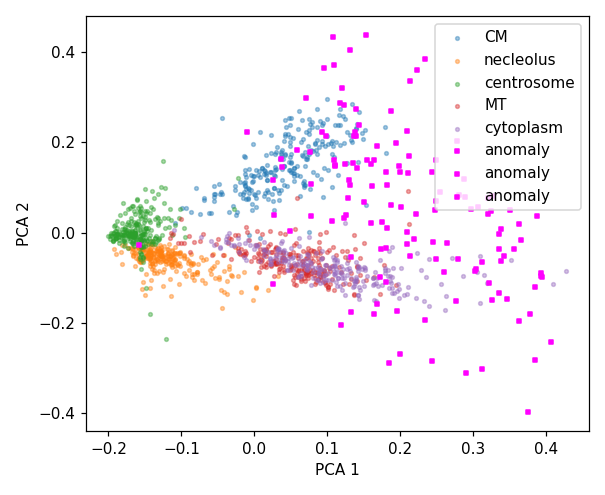

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torchvision

fig = plt.figure(figsize=(5.5, 4.5))
ax = fig.add_subplot()

idx2class = {0:'CM', 1:'necleolus', 2:'centrosome', 3:'MT', 4:'cytoplasm', \
             5:'A_CM', 6:'A_necleolus', 7:'A_centrosome', 8:'A_MT', 9:'A_cytoplasm'}

datain, labs = next(enumerate(test_loader_fc2_order))[1]
latent = datain.detach().numpy()
datain0, labs0 = next(enumerate(train_loader_fc2_order))[1]
latent = np.concatenate((datain, datain0.detach().numpy()), axis=0)
labs = torch.cat((labs, labs0))

""" Sub-division in anomaly group """
a_idx = np.where(labs == 5)
t1 = a_idx[0][0] + 35
t2 = t1 + 40
labs[t1:t2] = 6
t1 = t2
t2 += 47
labs[t1:t2] = 7
t1 = t2
t2 += 38
labs[t1:t2] = 8
t1 = t2
t2 += 57
labs[t1:t2] = 9

scaler = StandardScaler()
scaler.fit(latent)
latent = scaler.transform(latent)

pca_object = PCA(n_components=4)
principalComponents = pca_object.fit_transform(latent)
principalComponents[:,0] = principalComponents[:,0]/15
for i in range(10):
    idx = (labs == i)
    if i in [0,1,2,3,4]:
        ax.scatter(principalComponents[idx,0], principalComponents[idx,1], alpha=0.4, label=idx2class[i], s=6)
    elif i in [5,8,9]:
                ax.scatter(principalComponents[idx,0], principalComponents[idx,1], alpha=1.0, \
                           label='anomaly', s=6, color='magenta', marker='s')


# axes labels and title
ax.set_xlabel("PCA 1", fontname="Arial")
ax.set_ylabel("PCA 2", fontname="Arial")
#plt.title("title")

#auto legend setting and figure config
ax.legend()
plt.tight_layout()

plt.show()
#plt.savefig("figure.svg", dpi=300, format="svg")



## Spectral clustering 

In [29]:
idx = np.zeros(labs.shape, dtype=bool)
for i in [0, 1, 2, 3, 4, 5, 8, 9]:
    idx[labs == i] = True
    print(idx.sum())

240
480
720
960
1200
1236
1274
1331


In [28]:
idx = np.zeros(labs.shape, dtype=bool)

idx[labs == 7] = True
idx.sum()

47

In [31]:
latent.shape

(1418, 4)

<IPython.core.display.Javascript object>


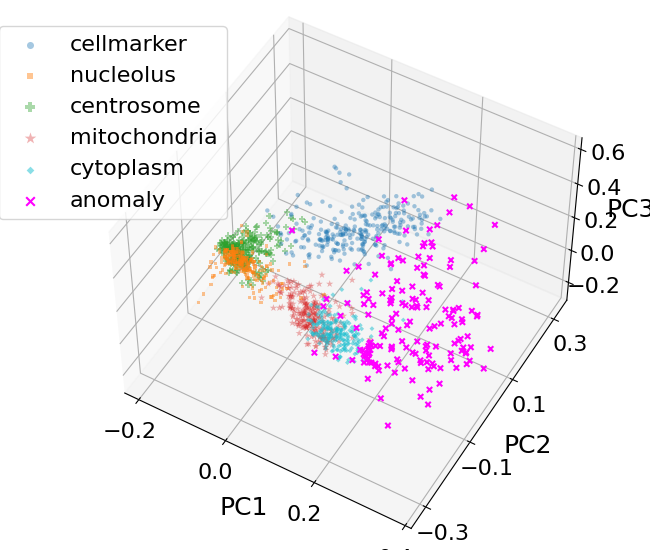

In [122]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering

fig = plt.figure(figsize=(6.5, 5.5))
ax = fig.add_subplot(projection='3d')

# datain, labs = next(enumerate(test_loader_fc2_order))[1]
# latent = datain.detach().numpy()
# datain0, labs0 = next(enumerate(train_loader_fc2_order))[1]
# latent = np.concatenate((datain, datain0.detach().numpy()), axis=0)
# labs = torch.cat((labs, labs0))

# idx = np.zeros(labs.shape, dtype=bool)
# for i in [0, 1, 2, 3, 4, 5, 8, 9]:
#     idx[labs == i] = True
# latent = latent[idx,:]
# sub_labs = labs[idx]

scaler = StandardScaler()
scaler.fit(latent)
latent = scaler.transform(latent)

pca_object = PCA(n_components=4)
principalComponents = pca_object.fit_transform(latent)
principalComponents[:,0] = principalComponents[:,0]/15

clustering = SpectralClustering(n_clusters=6,
        assign_labels='discretize', 
        affinity='nearest_neighbors',
        random_state=7).fit(principalComponents)
pred_labs = clustering.labels_ 

hs = []
mks = {0:'o', 1:'s', 2:"P", 3:"*", 4:"D", 5:"x"}
mksizes = {0:10, 1:6, 2:20, 3:30, 4:6, 5:10}
alphas = [0.4, 0.45, 0.4, 0.35, 0.5]
palette = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
color_remap = dict(zip(range(6), [0,1,2,3,9]))
for id, i in enumerate([3,4,1,0,2,5]):
    idx = (pred_labs == i)
#     ax.scatter(latent[idx,0], latent[idx,2], alpha=0.5, label=i,s=2)
    if id == 5:
        h = ax.scatter(principalComponents[idx,0], principalComponents[idx,1], principalComponents[idx,2], alpha=1, \
               label=f"group {id+1}", s=15, color='magenta', marker='x')
    else:
        h = ax.scatter(principalComponents[idx,0], principalComponents[idx,1], principalComponents[idx,2], alpha=alphas[id], \
                   label=f"group {id+1}", s=mksizes[id], color=palette[color_remap[id]], marker=mks[id], linewidth=0)
    hs.append(h)

# axes labels and title
ax.set_xlabel("PC1", fontname="Arial", fontsize=18)
ax.set_ylabel("PC2", fontname="Arial", fontsize=18)
ax.set_zlabel("PC3", fontname="Arial", fontsize=18)
ax.set_xticks(np.linspace(-0.2,0.4,4))
ax.set_yticks(np.linspace(-0.3,0.3,4))
ax.set_zticks(np.linspace(-0.2,0.6,5))
ax.set_xlim(-0.22, 0.4)
ax.set_ylim(-0.35, 0.35)
ax.view_init(50, -60)

#plt.title("title")

#auto legend setting and figure config
legend = plt.legend([hs[0], hs[1], hs[2], hs[3], hs[4], hs[5]], \
                   ["cellmarker", "nucleolus", "centrosome", "mitochondria", "cytoplasm",  "anomaly"], \
                   bbox_to_anchor=(-0.2, 0.5, 0.5, 0.5), \
                   markerscale=1.6)
plt.tight_layout()

plt.show()
plt.savefig("Spectral_clustering_latent_space_3D_v2.svg", dpi=300, format="svg")



In [ ]:
plt.figure()
A = clustering.affinity_matrix_
w, v = np.linalg.eig(A)
plt.scatter(np.arange(len(w)), np.sort(w), s = 2)
plt.yscale('log')

## Confusion matrix of spectral clustering 

<IPython.core.display.Javascript object>


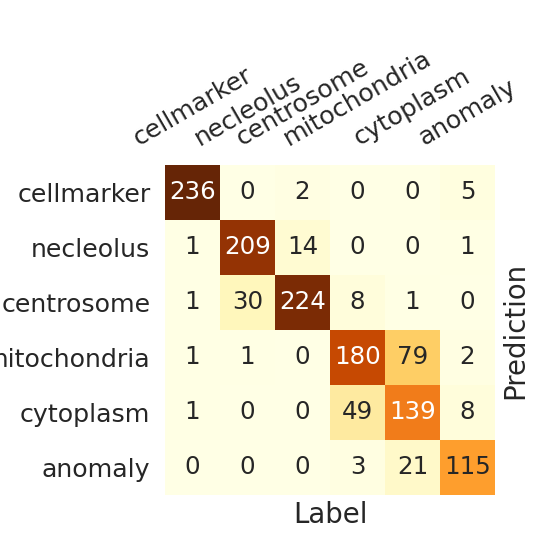

In [72]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas

conMat = {}
label_truth = sub_labs
label_truth[label_truth >= 5] = 5
for i in range(6):
    tmp = (label_truth == i)     
    conMat[f"label {i}"] = [(pred_labs[tmp] == j).sum().item() for j in [2, 0, 4, 1, 3, 5]] # The array is label to predict label mapping
df = pandas.DataFrame(conMat)

df = df.rename(columns=dict(zip(df.columns, ['cellmarker', 'necleolus', 'centrosome', 'mitochondria', 'cytoplasm', "anomaly"])), \
               index=dict(zip(df.index, ['cellmarker', 'necleolus', 'centrosome', 'mitochondria', 'cytoplasm', "anomaly"])))
df.index.name = 'Prediction'
df.columns.name = 'Label'
fig, ax = plt.subplots(1,1, figsize = (5,5))
ax.set_position([0.3,0.1,0.6,0.6])
sns.set(font_scale=1.5)#for label size
#df[df==0] = np.nan
sns.heatmap(df, cmap="YlOrBr", annot=True, annot_kws={"size": 16}, cbar=False, fmt='d')# font size
ax.tick_params(axis='x', rotation=30, labelbottom=False, bottom=False, top = False, labeltop=True)
ax.tick_params(axis='y', rotation=0, labelleft=True, labelright=False)
ax.yaxis.set_label_position("right")

# plt.tick_params(axis='both', which='major', labelsize=10, , )
# plt.savefig(f"./anomaly_detection_confusion_matrix.svg", dpi=300, format="svg")

# Plot thumbnails

In [73]:
%matplotlib notebook

In [74]:
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rcParams["font.family"] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [124]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

gray = cm.get_cmap('gray', 256)
gcmp = gray(np.linspace(0, 1, 256))
gcmp[:,0] = 0
gcmp[:,2] = 0

gcmp = ListedColormap(gcmp, name='gray_G')

<IPython.core.display.Javascript object>


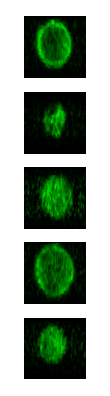

In [129]:
test_batch = next(enumerate(test_loader_fc2_order))[1]
test_labels = test_batch[1]
orig_images = test_batch[2]

fig, axes = plt.subplots(5, 1, figsize=(1.0,3.6))
# idx = [200+6, 200+126, 200+166, 200+15, 200+191]
idx = [8, 128, 168, 19, 193]

for ki, k in enumerate(idx):
    i = ki//5
    j = ki%5
    ax = axes[j]
    ax.imshow(orig_images[k,:].view(100,-1).detach().numpy(), cmap=gcmp)
    ax.axis("off")
    #ax.set_title(f"{idx2class[test_labels[k].item()]}", fontsize=10)

    plt.tight_layout()
    plt.show()
plt.savefig(f"./Cell_test_nomality_groundtruth_sampler3.svg", dpi=800, format="svg")

In [33]:
print(torch.__version__, optuna.__version__, ray.__version__)

1.11.0+cu102 1.5.0 1.11.0
